### Spark notebook ###

This notebook will only work in a Jupyter session running on `mathmadslinux2p`.

You can start your own Jupyter session on `mathmadslinux2p` and open this notebook in Chrome on the MADS Windows server by

**Steps**

1. Login to the MADS Windows server using https://mathportal.canterbury.ac.nz/.
2. Download or copy this notebook to your home directory.
3. Open powershell and run `ssh mathmadslinux2p`.
4. Run `start_pyspark_notebook` or `/opt/anaconda3/bin/jupyter-notebook --ip 132.181.129.68 --port $((8000 + $((RANDOM % 999))))`.
5. Copy / paste the url provided in the shell window into Chrome on the MADS Windows server.
6. Open the notebook from the Jupyter root directory (which is your home directory).
7. Run `start_spark()` to start a spark session in the notebook.
8. Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the Spark UI.

In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

### Example notebook ###

The code below provides a template for how you would use a notebook to start spark, run some code, and then stop spark.

**Steps**

- Run `start_spark()` to start a spark session in the notebook (only change the default resources when advised to do so for an exercise or assignment)
- Write and run code interactively, creating additional cells as needed.
- Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the [Spark UI](http://mathmadslinux2p.canterbury.ac.nz:8080/).

In [2]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)

spark.dynamicAllocation.enabled,false
spark.app.name,mli181 (jupyter)
spark.executor.instances,4
spark.driver.memory,4g
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.executor.cores,2
spark.driver.host,mathmadslinux2p.canterbury.ac.nz
spark.sql.shuffle.partitions,32
spark.app.startTime,1714532301035


In [3]:
# Write your imports here or insert cells below

from pyspark.sql import functions as F
from pyspark.sql.types import *

# processing Q2 (a)

In [7]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Read File") \
    .getOrCreate()
file_path = "hdfs:///data/ghcnd/daily/2023.csv.gz"

df = spark.read.csv(file_path)
df.show()

+-----------+--------+----+---+----+----+---+----+
|        _c0|     _c1| _c2|_c3| _c4| _c5|_c6| _c7|
+-----------+--------+----+---+----+----+---+----+
|AE000041196|20230101|TMAX|252|null|null|  S|null|
|AE000041196|20230101|TMIN|149|null|null|  S|null|
|AE000041196|20230101|PRCP|  0|   D|null|  S|null|
|AE000041196|20230101|TAVG|207|   H|null|  S|null|
|AEM00041194|20230101|TMAX|255|null|null|  S|null|
|AEM00041194|20230101|TMIN|186|null|null|  S|null|
|AEM00041194|20230101|PRCP|  0|null|null|  S|null|
|AEM00041194|20230101|TAVG|223|   H|null|  S|null|
|AEM00041217|20230101|TMAX|248|null|null|  S|null|
|AEM00041217|20230101|TMIN|184|null|null|  S|null|
|AEM00041217|20230101|TAVG|215|   H|null|  S|null|
|AEM00041218|20230101|TMAX|254|null|null|  S|null|
|AEM00041218|20230101|TMIN|145|null|null|  S|null|
|AEM00041218|20230101|TAVG|193|   H|null|  S|null|
|AG000060390|20230101|TMIN| 47|null|null|  S|null|
|AG000060390|20230101|TAVG|128|   H|null|  S|null|
|AG000060590|20230101|TAVG|134|

In [8]:
from pyspark.sql.functions import to_date, to_timestamp
df = df.withColumn("_c1", to_date(df["_c1"], "yyyyMMdd"))
df.show()

+-----------+----------+----+---+----+----+---+----+
|        _c0|       _c1| _c2|_c3| _c4| _c5|_c6| _c7|
+-----------+----------+----+---+----+----+---+----+
|AE000041196|2023-01-01|TMAX|252|null|null|  S|null|
|AE000041196|2023-01-01|TMIN|149|null|null|  S|null|
|AE000041196|2023-01-01|PRCP|  0|   D|null|  S|null|
|AE000041196|2023-01-01|TAVG|207|   H|null|  S|null|
|AEM00041194|2023-01-01|TMAX|255|null|null|  S|null|
|AEM00041194|2023-01-01|TMIN|186|null|null|  S|null|
|AEM00041194|2023-01-01|PRCP|  0|null|null|  S|null|
|AEM00041194|2023-01-01|TAVG|223|   H|null|  S|null|
|AEM00041217|2023-01-01|TMAX|248|null|null|  S|null|
|AEM00041217|2023-01-01|TMIN|184|null|null|  S|null|
|AEM00041217|2023-01-01|TAVG|215|   H|null|  S|null|
|AEM00041218|2023-01-01|TMAX|254|null|null|  S|null|
|AEM00041218|2023-01-01|TMIN|145|null|null|  S|null|
|AEM00041218|2023-01-01|TAVG|193|   H|null|  S|null|
|AG000060390|2023-01-01|TMIN| 47|null|null|  S|null|
|AG000060390|2023-01-01|TAVG|128|   H|null|  S

In [11]:
schema = StructType([
    StructField("ID", StringType(), True),
    StructField("DATE", DateType(), True),
    StructField("ELEMENT", StringType(), True),
    StructField("VALUE", FloatType(), True),
    StructField("MEASUREMENT FLAG", StringType(), True),
    StructField("QUALITY FLAG", StringType(), True),
    StructField("SOURCE FLAG", StringType(), True),
    StructField("OBSERVATION TIME", StringType(), True)
])

(b)

In [9]:
df = spark.read.csv(file_path, schema=schema, dateFormat = "yyyyMMdd").limit(1000)
df.show()

+-----------+----------+-------+-----+----------------+------------+-----------+----------------+
|         ID|      DATE|ELEMENT|VALUE|MEASUREMENT FLAG|QUALITY FLAG|SOURCE FLAG|OBSERVATION TIME|
+-----------+----------+-------+-----+----------------+------------+-----------+----------------+
|AE000041196|2023-01-01|   TMAX|252.0|            null|        null|          S|            null|
|AE000041196|2023-01-01|   TMIN|149.0|            null|        null|          S|            null|
|AE000041196|2023-01-01|   PRCP|  0.0|               D|        null|          S|            null|
|AE000041196|2023-01-01|   TAVG|207.0|               H|        null|          S|            null|
|AEM00041194|2023-01-01|   TMAX|255.0|            null|        null|          S|            null|
|AEM00041194|2023-01-01|   TMIN|186.0|            null|        null|          S|            null|
|AEM00041194|2023-01-01|   PRCP|  0.0|            null|        null|          S|            null|
|AEM00041194|2023-01

(c)

In [10]:
from pyspark.sql.functions import substring, trim
from pyspark.sql.types import StructType, StructField ,StringType, FloatType

In [12]:
stations = (
    spark.read.text("hdfs:///data/ghcnd/ghcnd-stations.txt")
    .select(
        trim(substring("value", 1, 11)).alias("ID"),
        trim(substring("value", 13, 8)).alias("LATITUDE"),
        trim(substring("value", 22, 9)).alias("LONGITUDE"),
        trim(substring("value", 32, 6)).alias("ELEVATION"),
        trim(substring("value", 39, 2)).alias("STATE"),
        trim(substring("value", 42, 30)).alias("NAME"),
        trim(substring("value", 73, 3)).alias("GSN FLAG"),
        trim(substring("value", 77, 3)).alias("HCN/CRN FLAG"),
        trim(substring("value", 81, 5)).alias("WMO ID")
    )
)
stations.show()

+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+
|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN FLAG|HCN/CRN FLAG|WMO ID|
+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+
|ACW00011604| 17.1167| -61.7833|     10.1|     |ST JOHNS COOLIDGE...|        |            |      |
|ACW00011647| 17.1333| -61.7833|     19.2|     |            ST JOHNS|        |            |      |
|AE000041196| 25.3330|  55.5170|     34.0|     | SHARJAH INTER. AIRP|     GSN|            | 41196|
|AEM00041194| 25.2550|  55.3640|     10.4|     |          DUBAI INTL|        |            | 41194|
|AEM00041217| 24.4330|  54.6510|     26.8|     |      ABU DHABI INTL|        |            | 41217|
|AEM00041218| 24.2620|  55.6090|    264.9|     |         AL AIN INTL|        |            | 41218|
|AF000040930| 35.3170|  69.0170|   3366.0|     |        NORTH-SALANG|     GSN|            | 40930|
|AFM000409

In [13]:
row_total = stations.count()
without_id = stations.filter(stations["WMO ID"] == "").count()
print(row_total)
print(without_id)

125983
118023


In [14]:
states = (
    spark.read.text("hdfs:///data/ghcnd/ghcnd-states.txt")
    .select(
        trim(substring("value", 1, 2)).alias("CODE"),
        trim(substring("value", 4, 50)).alias("NAME")
    )
)
states.show()

+----+--------------------+
|CODE|                NAME|
+----+--------------------+
|  AB|             ALBERTA|
|  AK|              ALASKA|
|  AL|             ALABAMA|
|  AR|            ARKANSAS|
|  AS|      AMERICAN SAMOA|
|  AZ|             ARIZONA|
|  BC|    BRITISH COLUMBIA|
|  CA|          CALIFORNIA|
|  CO|            COLORADO|
|  CT|         CONNECTICUT|
|  DC|DISTRICT OF COLUMBIA|
|  DE|            DELAWARE|
|  FL|             FLORIDA|
|  FM|          MICRONESIA|
|  GA|             GEORGIA|
|  GU|                GUAM|
|  HI|              HAWAII|
|  IA|                IOWA|
|  ID|               IDAHO|
|  IL|            ILLINOIS|
+----+--------------------+
only showing top 20 rows



In [15]:
row_total = states.count()
print(row_total)

74


In [16]:
countries = (
    spark.read.text("hdfs:///data/ghcnd/ghcnd-countries.txt")
    .select(
        trim(substring("value", 1, 2)).alias("CODE"),
        trim(substring("value", 4, 64)).alias("NAME")
    )
)
countries.show()

+----+--------------------+
|CODE|                NAME|
+----+--------------------+
|  AC| Antigua and Barbuda|
|  AE|United Arab Emirates|
|  AF|         Afghanistan|
|  AG|             Algeria|
|  AJ|          Azerbaijan|
|  AL|             Albania|
|  AM|             Armenia|
|  AO|              Angola|
|  AQ|American Samoa [U...|
|  AR|           Argentina|
|  AS|           Australia|
|  AU|             Austria|
|  AY|          Antarctica|
|  BA|             Bahrain|
|  BB|            Barbados|
|  BC|            Botswana|
|  BD|Bermuda [United K...|
|  BE|             Belgium|
|  BF|        Bahamas, The|
|  BG|          Bangladesh|
+----+--------------------+
only showing top 20 rows



In [17]:
row_total = countries.count()
print(row_total)

219


In [18]:
inventory = (
    spark.read.text("hdfs:///data/ghcnd/ghcnd-inventory.txt")
    .select(
        trim(substring("value", 1, 11)).alias("ID"),
        trim(substring("value", 13, 8)).alias("LATITUDE"),
        trim(substring("value", 22, 9)).alias("LONGITUDE"),
        trim(substring("value", 32, 4)).alias("ELEMENT"),
        trim(substring("value", 37, 4).cast("int")).alias("FIRSTYEAR"),
        trim(substring("value", 42, 4).cast("int")).alias("LASTYEAR")
    )
)
inventory.show()

+-----------+--------+---------+-------+---------+--------+
|         ID|LATITUDE|LONGITUDE|ELEMENT|FIRSTYEAR|LASTYEAR|
+-----------+--------+---------+-------+---------+--------+
|ACW00011604| 17.1167| -61.7833|   TMAX|     1949|    1949|
|ACW00011604| 17.1167| -61.7833|   TMIN|     1949|    1949|
|ACW00011604| 17.1167| -61.7833|   PRCP|     1949|    1949|
|ACW00011604| 17.1167| -61.7833|   SNOW|     1949|    1949|
|ACW00011604| 17.1167| -61.7833|   SNWD|     1949|    1949|
|ACW00011604| 17.1167| -61.7833|   PGTM|     1949|    1949|
|ACW00011604| 17.1167| -61.7833|   WDFG|     1949|    1949|
|ACW00011604| 17.1167| -61.7833|   WSFG|     1949|    1949|
|ACW00011604| 17.1167| -61.7833|   WT03|     1949|    1949|
|ACW00011604| 17.1167| -61.7833|   WT08|     1949|    1949|
|ACW00011604| 17.1167| -61.7833|   WT16|     1949|    1949|
|ACW00011647| 17.1333| -61.7833|   TMAX|     1961|    1961|
|ACW00011647| 17.1333| -61.7833|   TMIN|     1961|    1961|
|ACW00011647| 17.1333| -61.7833|   PRCP|

In [19]:
row_total = inventory.count()
print(row_total)

747382


Q3(a)

In [20]:
stations_code = stations.withColumn(
"COUNTRY CODE", substring("ID", 1, 2)
)
stations_code.show()

+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+
|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN FLAG|HCN/CRN FLAG|WMO ID|COUNTRY CODE|
+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+
|ACW00011604| 17.1167| -61.7833|     10.1|     |ST JOHNS COOLIDGE...|        |            |      |          AC|
|ACW00011647| 17.1333| -61.7833|     19.2|     |            ST JOHNS|        |            |      |          AC|
|AE000041196| 25.3330|  55.5170|     34.0|     | SHARJAH INTER. AIRP|     GSN|            | 41196|          AE|
|AEM00041194| 25.2550|  55.3640|     10.4|     |          DUBAI INTL|        |            | 41194|          AE|
|AEM00041217| 24.4330|  54.6510|     26.8|     |      ABU DHABI INTL|        |            | 41217|          AE|
|AEM00041218| 24.2620|  55.6090|    264.9|     |         AL AIN INTL|        |            | 41218|      

(b)

In [21]:
stations_countries = stations_code.join(
    countries,
    stations_code["COUNTRY CODE"] == countries["CODE"],
    "left"
)
stations_countries.show()

+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+----+--------------------+
|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN FLAG|HCN/CRN FLAG|WMO ID|COUNTRY CODE|CODE|                NAME|
+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+----+--------------------+
|ACW00011604| 17.1167| -61.7833|     10.1|     |ST JOHNS COOLIDGE...|        |            |      |          AC|  AC| Antigua and Barbuda|
|ACW00011647| 17.1333| -61.7833|     19.2|     |            ST JOHNS|        |            |      |          AC|  AC| Antigua and Barbuda|
|AE000041196| 25.3330|  55.5170|     34.0|     | SHARJAH INTER. AIRP|     GSN|            | 41196|          AE|  AE|United Arab Emirates|
|AEM00041194| 25.2550|  55.3640|     10.4|     |          DUBAI INTL|        |            | 41194|          AE|  AE|United Arab Emirates|
|AEM00041217| 24.4330|  54.6510|  

In [22]:
us_rows = stations_code.filter(stations_code["COUNTRY CODE"] == "US")
us_rows.show()

+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+
|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN FLAG|HCN/CRN FLAG|WMO ID|COUNTRY CODE|
+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+
|US009052008| 43.7333| -96.6333|    482.0|   SD|SIOUX FALLS (ENVI...|        |            |      |          US|
|US10RMHS145| 40.5268|-105.1113|   1569.1|   CO|        RMHS 1.6 SSW|        |            |      |          US|
|US10adam001| 40.5680| -98.5069|    598.0|   NE|       JUNIATA 1.5 S|        |            |      |          US|
|US10adam002| 40.5093| -98.5493|    601.1|   NE|     JUNIATA 6.0 SSW|        |            |      |          US|
|US10adam003| 40.4663| -98.6537|    615.1|   NE|     HOLSTEIN 0.1 NW|        |            |      |          US|
|US10adam004| 40.4798| -98.4026|    570.0|   NE|          AYR 3.5 NE|        |            |      |      

(c)

In [23]:
from pyspark.sql.functions import length
stations_states = stations_code.join(
    states,
    ((length(stations_code["STATE"]) > 1) & 
    (stations_code["STATE"] == states["CODE"]) &
    (stations_code["COUNTRY CODE"] == "US")),  
    "left"
)
stations_states.show()


+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+----+----+
|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN FLAG|HCN/CRN FLAG|WMO ID|COUNTRY CODE|CODE|NAME|
+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+----+----+
|ACW00011604| 17.1167| -61.7833|     10.1|     |ST JOHNS COOLIDGE...|        |            |      |          AC|null|null|
|ACW00011647| 17.1333| -61.7833|     19.2|     |            ST JOHNS|        |            |      |          AC|null|null|
|AE000041196| 25.3330|  55.5170|     34.0|     | SHARJAH INTER. AIRP|     GSN|            | 41196|          AE|null|null|
|AEM00041194| 25.2550|  55.3640|     10.4|     |          DUBAI INTL|        |            | 41194|          AE|null|null|
|AEM00041217| 24.4330|  54.6510|     26.8|     |      ABU DHABI INTL|        |            | 41217|          AE|null|null|
|AEM00041218| 24.2620|  

In [24]:
filtered = stations_states.filter(stations_states["STATE"] != "")
filtered.show()

+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+----+----+
|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN FLAG|HCN/CRN FLAG|WMO ID|COUNTRY CODE|CODE|NAME|
+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+----+----+
|AGM00060620| 27.838 |         |         |     |                 ...|        |            |      |          AG|null|null|
|AQC00914000|-14.3167|-170.7667|    408.4|   AS|             AASUFOU|        |            |      |          AQ|null|null|
|AQC00914005|-14.2667|-170.6500|    182.9|   AS|               AFONO|        |            |      |          AQ|null|null|
|AQC00914021|-14.2667|-170.5833|      6.1|   AS|      AMOULI TUTUILA|        |            |      |          AQ|null|null|
|AQC00914060|-14.2667|-170.6833|     80.8|   AS|                ATUU|        |            |      |          AQ|null|null|
|AQC00914135|-14.3000|-1

In [25]:
us_df = filtered.filter(filtered["COUNTRY CODE"] == "US")
us_df.show()

+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+----+------------+
|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN FLAG|HCN/CRN FLAG|WMO ID|COUNTRY CODE|CODE|        NAME|
+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+----+------------+
|US009052008| 43.7333| -96.6333|    482.0|   SD|SIOUX FALLS (ENVI...|        |            |      |          US|  SD|SOUTH DAKOTA|
|US10RMHS145| 40.5268|-105.1113|   1569.1|   CO|        RMHS 1.6 SSW|        |            |      |          US|  CO|    COLORADO|
|US10adam001| 40.5680| -98.5069|    598.0|   NE|       JUNIATA 1.5 S|        |            |      |          US|  NE|    NEBRASKA|
|US10adam002| 40.5093| -98.5493|    601.1|   NE|     JUNIATA 6.0 SSW|        |            |      |          US|  NE|    NEBRASKA|
|US10adam003| 40.4663| -98.6537|    615.1|   NE|     HOLSTEIN 0.1 NW|        |            

In [26]:
stations_stated = us_df.join(
    states,
    us_df["STATE"] == states["CODE"],
    "left"
)
stations_stated.show()

+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+----+------------+----+--------------------+
|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN FLAG|HCN/CRN FLAG|WMO ID|COUNTRY CODE|CODE|        NAME|CODE|                NAME|
+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+----+------------+----+--------------------+
|US009052008| 43.7333| -96.6333|    482.0|   SD|SIOUX FALLS (ENVI...|        |            |      |          US|  SD|SOUTH DAKOTA|  AB|             ALBERTA|
|US009052008| 43.7333| -96.6333|    482.0|   SD|SIOUX FALLS (ENVI...|        |            |      |          US|  SD|SOUTH DAKOTA|  AK|              ALASKA|
|US009052008| 43.7333| -96.6333|    482.0|   SD|SIOUX FALLS (ENVI...|        |            |      |          US|  SD|SOUTH DAKOTA|  AL|             ALABAMA|
|US009052008| 43.7333| -96.6333|    482.0|   SD|SIOUX FALLS (ENV

d

In [81]:
from pyspark.sql.functions import min, max
element_notnull = inventory.filter((col("ELEMENT") != "") & (col("ELEMENT") != "null"))
station_year = element_notnull.groupBy("ID").agg(
    min("FIRSTYEAR").alias("first year"),
    max("LASTYEAR").alias("last year")
)
station_year.show()

+-----------+----------+---------+
|         ID|first year|last year|
+-----------+----------+---------+
|AGE00147719|      1888|     2024|
|ALE00100939|      1940|     2000|
|AQC00914873|      1955|     1967|
|AR000000002|      1981|     2000|
|AR000875850|      1908|     2024|
|ARM00087022|      1973|     2024|
|ARM00087480|      1965|     2024|
|ARM00087904|      2003|     2024|
|ASN00001003|      1909|     1940|
|ASN00002033|      1920|     1965|
|ASN00002042|      1932|     1993|
|ASN00003021|      1899|     1992|
|ASN00003047|      1929|     1940|
|ASN00003069|      1974|     1992|
|ASN00004031|      1949|     1983|
|ASN00004047|      1924|     1976|
|ASN00004062|      1913|     1942|
|ASN00004087|      1984|     1986|
|ASN00005004|      1915|     2022|
|ASN00006011|      1750|     2024|
+-----------+----------+---------+
only showing top 20 rows



In [28]:
from pyspark.sql.functions import countDistinct

element_total = inventory.groupBy("ID").agg(
    countDistinct("ELEMENT").alias("number")
)

element_total.show()

+-----------+------+
|         ID|number|
+-----------+------+
|CA006166418|     6|
|CA007027040|     7|
|CA007041166|     6|
|CA007047735|     7|
|CA007052600|     7|
|CA007077571|     7|
|CA00709CEE9|     7|
|CA008204477|     5|
|CA008400800|     7|
|CA008502200|     6|
|CA1NB000159|     7|
|CA1NL000069|     7|
|CA1NS000094|     7|
|CA1ON000070|     7|
|CA1ON000224|     7|
|CA1ON000587|     1|
|CA1ON000931|     5|
|CHM00045005|     4|
|CHM00057745|     4|
|COM00080094|     4|
+-----------+------+
only showing top 20 rows



In [29]:
from pyspark.sql.functions import col

core_elements = ["TMAX", "TMIN", "PRCP", "SNOW", "SNWD"]
core_inventory = inventory.filter(col("ELEMENT").isin(core_elements))
core_element_count = core_inventory.groupBy("ID").agg(
    countDistinct("ELEMENT").alias("core_elements")
)

core_elements_count = core_element_count.filter(core_element_count["core_elements"] == 5).count()
print("Number of stations collecting all five core elements:", core_elements_count)

Number of stations collecting all five core elements: 20467


In [30]:
from pyspark.sql.functions import col, count, when

precipitation_stations = inventory \
    .distinct() \
    .groupBy("ID") \
    .agg(
        count("ELEMENT").alias("elements_count"),
        count(when(col("ELEMENT") == "PRCP", 1)).alias("precipitation_count")
    ) \
    .filter((col("elements_count") == 1) & (col("precipitation_count") == 1))
print(precipitation_stations.count())

16301


In [31]:
core_element_count.show()

+-----------+-------------+
|         ID|core_elements|
+-----------+-------------+
|CA006166800|            4|
|CA007034395|            5|
|CA007037400|            5|
|CA007054640|            5|
|CA007095409|            4|
|CA008103000|            5|
|CA00810M937|            5|
|CA008200155|            5|
|CA1QC000033|            3|
|CD000004753|            3|
|CHM00056985|            4|
|COM00080094|            3|
|FIE00145137|            1|
|FIE00145267|            1|
|GME00129202|            4|
|GME00131614|            4|
|IN005030800|            1|
|IN009062700|            1|
|IN017101800|            1|
|IN020123400|            1|
+-----------+-------------+
only showing top 20 rows



In [78]:
station_elements = element_total.join(
    core_element_count,
    element_total["element_id"] == core_element_count["core_id"],
    "left"
)

station_elements = station_elements.withColumn(
    "OTHER_ELEMENTS",
    station_elements["number"] - station_elements["core_elements"]
)

station_elements.show()

+-----------+------+-----------+-------------+--------------+
| element_id|number|    core_id|core_elements|OTHER_ELEMENTS|
+-----------+------+-----------+-------------+--------------+
|AGE00147719|     4|AGE00147719|            3|             1|
|ALE00100939|     2|ALE00100939|            2|             0|
|AQC00914873|    12|AQC00914873|            5|             7|
|AR000000002|     1|AR000000002|            1|             0|
|AR000875850|     5|AR000875850|            4|             1|
|ARM00087022|     4|ARM00087022|            3|             1|
|ARM00087480|     5|ARM00087480|            4|             1|
|ARM00087904|     5|ARM00087904|            4|             1|
|ASN00001003|     1|ASN00001003|            1|             0|
|ASN00002033|     1|ASN00002033|            1|             0|
|ASN00002042|     4|ASN00002042|            1|             3|
|ASN00003021|     4|ASN00003021|            1|             3|
|ASN00003047|     1|ASN00003047|            1|             0|
|ASN0000

In [32]:
precipitation_stations.show()

+-----------+--------------+-------------------+
|         ID|elements_count|precipitation_count|
+-----------+--------------+-------------------+
|IN011410300|             1|                  1|
|IN017110700|             1|                  1|
|IN023481200|             1|                  1|
|UPM00033374|             1|                  1|
|ASN00040044|             1|                  1|
|ASN00040836|             1|                  1|
|ASN00041309|             1|                  1|
|ASN00041374|             1|                  1|
|BR001150001|             1|                  1|
|BR001840013|             1|                  1|
|BR027798970|             1|                  1|
|FIE00144337|             1|                  1|
|FIE00145067|             1|                  1|
|IN001090100|             1|                  1|
|IN005140400|             1|                  1|
|IN017101800|             1|                  1|
|KZ000036513|             1|                  1|
|ASN00010234|       

e

In [33]:
stations = stations.withColumnRenamed("ID", "stations_id")
station_year = station_year.withColumnRenamed("ID", "years_id")
combined_stations = stations.join(
    station_year,
    stations["stations_id"] == station_year["years_id"],
    "left"
)
combined_stations.show()

+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+-----------+----------+---------+
|stations_id|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN FLAG|HCN/CRN FLAG|WMO ID|   years_id|first year|last year|
+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+-----------+----------+---------+
|AE000041196| 25.3330|  55.5170|     34.0|     | SHARJAH INTER. AIRP|     GSN|            | 41196|AE000041196|      1944|     2024|
|AEM00041218| 24.2620|  55.6090|    264.9|     |         AL AIN INTL|        |            | 41218|AEM00041218|      1994|     2024|
|RSM00031913| 45.2170| 131.9830|     88.0|     |           TURIJ ROG|        |            | 31913|RSM00031913|      1936|     2018|
|AG000060590| 30.5667|   2.8667|    397.0|     |            EL-GOLEA|     GSN|            | 60590|AG000060590|      1892|     2024|
|AGE00147706| 36.8000|   3.0300|    344.0|     |   ALGIERS-BOUZAREAH|       

In [34]:
element_total = element_total.withColumnRenamed("ID", "element_id")
combined_stations = combined_stations.join(
    element_total,
    combined_stations["stations_id"] == element_total["element_id"],
    "left"
)
combined_stations.show()

+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+-----------+----------+---------+-----------+------+
|stations_id|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN FLAG|HCN/CRN FLAG|WMO ID|   years_id|first year|last year| element_id|number|
+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+-----------+----------+---------+-----------+------+
|AGE00147719| 33.7997|   2.8900|    767.0|     |            LAGHOUAT|        |            | 60545|AGE00147719|      1888|     2024|AGE00147719|     4|
|ALE00100939| 41.3331|  19.7831|     89.0|     |              TIRANA|        |            |      |ALE00100939|      1940|     2000|ALE00100939|     2|
|AQC00914873|-14.3500|-170.7667|     14.9|   AS|    TAPUTIMU TUTUILA|        |            |      |AQC00914873|      1955|     1967|AQC00914873|    12|
|AR000000002|-29.8200| -57.4200|     75.0|     |            BONPLAND|        |            |   

In [35]:
core_element_count = core_element_count.withColumnRenamed("ID", "core_id")

combined_stations = combined_stations.join(
    core_element_count,
    combined_stations["stations_id"] == core_element_count["core_id"],
    "left"
)
combined_stations.show()

+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+-----------+----------+---------+-----------+------+-----------+-------------+
|stations_id|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN FLAG|HCN/CRN FLAG|WMO ID|   years_id|first year|last year| element_id|number|    core_id|core_elements|
+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+-----------+----------+---------+-----------+------+-----------+-------------+
|AGE00147719| 33.7997|   2.8900|    767.0|     |            LAGHOUAT|        |            | 60545|AGE00147719|      1888|     2024|AGE00147719|     4|AGE00147719|            3|
|ALE00100939| 41.3331|  19.7831|     89.0|     |              TIRANA|        |            |      |ALE00100939|      1940|     2000|ALE00100939|     2|ALE00100939|            2|
|AQC00914873|-14.3500|-170.7667|     14.9|   AS|    TAPUTIMU TUTUILA|        |            |      |AQC00914873|     

In [36]:
precipitation_stations = precipitation_stations.withColumnRenamed("ID", "prec_id")

combined_stations = combined_stations.join(
    precipitation_stations,
    combined_stations["stations_id"] == precipitation_stations["prec_id"],
    "left"
)
combined_stations.show()

+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+-----------+----------+---------+-----------+------+-----------+-------------+-----------+--------------+-------------------+
|stations_id|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN FLAG|HCN/CRN FLAG|WMO ID|   years_id|first year|last year| element_id|number|    core_id|core_elements|    prec_id|elements_count|precipitation_count|
+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+-----------+----------+---------+-----------+------+-----------+-------------+-----------+--------------+-------------------+
|AGE00147719| 33.7997|   2.8900|    767.0|     |            LAGHOUAT|        |            | 60545|AGE00147719|      1888|     2024|AGE00147719|     4|AGE00147719|            3|       null|          null|               null|
|ALE00100939| 41.3331|  19.7831|     89.0|     |              TIRANA|        |            |      |ALE001

In [37]:
combined_stations.write.csv("hdfs:///user/mli181/output/combined_stations.csv", header=True, mode="overwrite")

f

In [38]:
df = df.withColumnRenamed("ID", "daily_id")
daily_stations = combined_stations.join(
    df,
    combined_stations["stations_id"] == df["daily_id"],
    "left"
)
daily_stations.show()

+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+-----------+----------+---------+-----------+------+-----------+-------------+-----------+--------------+-------------------+-----------+----------+-------+-----+----------------+------------+-----------+----------------+
|stations_id|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN FLAG|HCN/CRN FLAG|WMO ID|   years_id|first year|last year| element_id|number|    core_id|core_elements|    prec_id|elements_count|precipitation_count|   daily_id|      DATE|ELEMENT|VALUE|MEASUREMENT FLAG|QUALITY FLAG|SOURCE FLAG|OBSERVATION TIME|
+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+-----------+----------+---------+-----------+------+-----------+-------------+-----------+--------------+-------------------+-----------+----------+-------+-----+----------------+------------+-----------+----------------+
|AGE00147719| 33.7997|   2.8900|    767.

It should cost a lot, because there are over 1000 rows and many columns at same time.

In [39]:
missing_stations = df.select("daily_id").subtract(stations.select("stations_id"))
missing_stations.show()

+-----------+
|   daily_id|
+-----------+
|AGM00060640|
|AGM00060656|
|AGM00060670|
+-----------+



analysis Q1 a

In [40]:
station_count = stations.select("stations_id").distinct().count()
print("Number of stations:", station_count)

Number of stations: 125983


In [41]:
station_2024 = daily_stations.filter(daily_stations["last year"] == 2024)

In [42]:
count_2024 = station_2024.select("stations_id").distinct().count()
print(count_2024)

31837


In [43]:
network_counts = daily_stations.groupBy("GSN FLAG", "HCN/CRN FLAG").agg(countDistinct("stations_id").alias("count"))
network_counts.show()

+--------+------------+------+
|GSN FLAG|HCN/CRN FLAG| count|
+--------+------------+------+
|     GSN|            |   976|
|        |         HCN|  1203|
|     GSN|         HCN|    15|
|        |         CRN|   234|
|        |            |123554|
|        |            |     1|
+--------+------------+------+



In [87]:
multi_count = daily_stations.filter((daily_stations["GSN FLAG"] != "") & (daily_stations["HCN/CRN FLAG"] == "CRN")) \
                            .agg(countDistinct("stations_id").alias("multi_count"))
multi_count.show()

+-----------+
|multi_count|
+-----------+
|          0|
+-----------+



b

In [45]:
stations_per_country = stations_countries.groupBy("COUNTRY CODE").agg(countDistinct("ID").alias("total_stations"))
countries_with_stations = countries.join(stations_per_country, countries["CODE"] == stations_per_country["COUNTRY CODE"], "left")
countries_with_stations.show()
countries_with_stations.write.csv("hdfs:///user/mli181/output/countries_with_stations.csv", header=True)

+----+--------------------+------------+--------------+
|CODE|                NAME|COUNTRY CODE|total_stations|
+----+--------------------+------------+--------------+
|  BB|            Barbados|          BB|             1|
|  TI|          Tajikistan|          TI|            62|
|  BG|          Bangladesh|          BG|            10|
|  CA|              Canada|          CA|          9188|
|  MX|              Mexico|          MX|          5249|
|  MZ|          Mozambique|          MZ|            19|
|  NI|             Nigeria|          NI|            10|
|  SW|              Sweden|          SW|          1721|
|  UG|              Uganda|          UG|             8|
|  WQ|Wake Island [Unit...|          WQ|             1|
|  GH|               Ghana|          GH|            18|
|  GM|             Germany|          GM|          1123|
|  BN|               Benin|          BN|             9|
|  CH|               China|          CH|           228|
|  HU|             Hungary|          HU|        

AnalysisException: path hdfs://masternode2:9000/user/mli181/output/countries_with_stations.csv already exists.

In [46]:
states= states.withColumnRenamed("CODE", "states_code")
stations_per_states = stations_states.groupBy("CODE").agg(countDistinct("ID").alias("total_stations"))
states_with_stations = states.join(stations_per_states, states["states_code"] == stations_per_states["CODE"], "left")
states_with_stations.show()
states_with_stations.write.csv("hdfs:///user/mli181/output/states_with_stations.csv", header=True)

+-----------+--------------------+----+--------------+
|states_code|                NAME|CODE|total_stations|
+-----------+--------------------+----+--------------+
|         NT|NORTHWEST TERRITO...|null|          null|
|         PI|     PACIFIC ISLANDS|null|          null|
|         CA|          CALIFORNIA|  CA|          3080|
|         OK|            OKLAHOMA|  OK|          1081|
|         MN|           MINNESOTA|  MN|          2199|
|         ND|        NORTH DAKOTA|  ND|           574|
|         NH|       NEW HAMPSHIRE|  NH|           471|
|         OH|                OHIO|  OH|          1397|
|         WI|           WISCONSIN|  WI|          1412|
|         AZ|             ARIZONA|  AZ|          1655|
|         MB|            MANITOBA|null|          null|
|         FM|          MICRONESIA|null|          null|
|         MH|    MARSHALL ISLANDS|null|          null|
|         NM|          NEW MEXICO|  NM|          2234|
|         AL|             ALABAMA|  AL|          1101|
|         

AnalysisException: path hdfs://masternode2:9000/user/mli181/output/states_with_stations.csv already exists.

c

In [47]:
southern_hemisphere = daily_stations.filter(daily_stations["LATITUDE"] < 0)
southern_count = southern_hemisphere.select("stations_id").distinct().count()
print("Number of stations in the Southern Hemisphere:", southern_count)

Number of stations in the Southern Hemisphere: 25316


In [90]:
territories_of_us = countries_with_stations.filter(col("NAME").contains("United States") & (col("COUNTRY CODE") != "US"))
territories_of_us_station_count = territories_of_us.groupBy().sum("total_stations").collect()[0][0]

print("Number of stations in us(not itself) territories:", territories_of_us_station_count)

Number of stations in us(not itself) territories: 386


Q2 A

In [49]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType
import math

@udf(DoubleType())
def calculate_distance(lat1, lon1, lat2, lon2):
    radius = 6371.0

    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance_km = radius * c
    return distance_km

In [50]:
stations_countries.show()

+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+----+--------------------+
|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN FLAG|HCN/CRN FLAG|WMO ID|COUNTRY CODE|CODE|                NAME|
+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+----+--------------------+
|ACW00011604| 17.1167| -61.7833|     10.1|     |ST JOHNS COOLIDGE...|        |            |      |          AC|  AC| Antigua and Barbuda|
|ACW00011647| 17.1333| -61.7833|     19.2|     |            ST JOHNS|        |            |      |          AC|  AC| Antigua and Barbuda|
|AE000041196| 25.3330|  55.5170|     34.0|     | SHARJAH INTER. AIRP|     GSN|            | 41196|          AE|  AE|United Arab Emirates|
|AEM00041194| 25.2550|  55.3640|     10.4|     |          DUBAI INTL|        |            | 41194|          AE|  AE|United Arab Emirates|
|AEM00041217| 24.4330|  54.6510|  

In [51]:
subset_stations = stations_countries.limit(2)
subset_stations.show()
subset_stations = subset_stations.withColumn("LATITUDE", col("LATITUDE").cast("float"))
subset_stations = subset_stations.withColumn("LONGITUDE", col("LONGITUDE").cast("float"))

subset_stations_renamed = (subset_stations.withColumnRenamed("LATITUDE", "lat2").withColumnRenamed("LONGITUDE", "lon2").withColumnRenamed("ELEVATION", "ELEVATION2")
.withColumnRenamed("STATE", "STATE2").withColumnRenamed("NAME", "NAME2").withColumnRenamed("GSN_FLAG", "GSN_FLAG2").withColumnRenamed("HCN_CRN_FLAG", "HCN_CRN_FLAG2")
.withColumnRenamed("WMO_ID", "WMO_ID2").withColumnRenamed("COUNTRY CODE", "COUNTRY CODE2").withColumnRenamed("CODE", "CODE2").withColumnRenamed("NAME", "NAME")                           )
subset_stations_renamed = subset_stations_renamed.withColumn("lat2", col("lat2").cast("float"))
subset_stations_renamed = subset_stations_renamed.withColumn("lon2", col("lon2").cast("float"))

station_pairs = subset_stations.crossJoin(subset_stations_renamed)
station_pairs.show()

+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+----+-------------------+
|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|                NAME|GSN FLAG|HCN/CRN FLAG|WMO ID|COUNTRY CODE|CODE|               NAME|
+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+----+-------------------+
|ACW00011604| 17.1167| -61.7833|     10.1|     |ST JOHNS COOLIDGE...|        |            |      |          AC|  AC|Antigua and Barbuda|
|ACW00011647| 17.1333| -61.7833|     19.2|     |            ST JOHNS|        |            |      |          AC|  AC|Antigua and Barbuda|
+-----------+--------+---------+---------+-----+--------------------+--------+------------+------+------------+----+-------------------+

+-----------+--------+---------+---------+-----+------------------+--------+------------+------+------------+----+-------------+-----------+-------+--------+----------+------+--

In [52]:
station_pairs_distance = station_pairs.withColumn("distance_km", calculate_distance(col("LATITUDE"), col("LONGITUDE"), col("lat2"), col("lon2")))
station_pairs_distance.show()

+-----------+--------+---------+---------+-----+------------------+--------+------------+------+------------+----+-------------+-----------+-------+--------+----------+------+--------------------+--------+------------+------+-------------+-----+-------------------+------------------+
|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|              NAME|GSN FLAG|HCN/CRN FLAG|WMO ID|COUNTRY CODE|CODE|         NAME|         ID|   lat2|    lon2|ELEVATION2|STATE2|               NAME2|GSN FLAG|HCN/CRN FLAG|WMO ID|COUNTRY CODE2|CODE2|              NAME2|       distance_km|
+-----------+--------+---------+---------+-----+------------------+--------+------------+------+------------+----+-------------+-----------+-------+--------+----------+------+--------------------+--------+------------+------+-------------+-----+-------------------+------------------+
|US1WYCK0007| 44.3525| -104.257|   1541.1|   WY|  SUNDANCE 6.0 ESE|        |            |      |          US|  US|United States|ACW00011604|17.11

b

In [53]:
nz_stations = stations_countries.filter(stations_countries["CODE"] == "NZ")
nz_stations = nz_stations.withColumn("LATITUDE", col("LATITUDE").cast("float"))
nz_stations = nz_stations.withColumn("LONGITUDE", col("LONGITUDE").cast("float"))
nz_stations.show()

+-----------+--------+---------+---------+-----+-------------------+--------+------------+------+------------+----+-----------+
|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|               NAME|GSN FLAG|HCN/CRN FLAG|WMO ID|COUNTRY CODE|CODE|       NAME|
+-----------+--------+---------+---------+-----+-------------------+--------+------------+------+------------+----+-----------+
|NZ000093012|   -35.1|  173.267|     54.0|     |            KAITAIA|        |            | 93119|          NZ|  NZ|New Zealand|
|NZ000093292|  -38.65|  177.983|      5.0|     | GISBORNE AERODROME|     GSN|            | 93292|          NZ|  NZ|New Zealand|
|NZ000093417|   -40.9|  174.983|      7.0|     |    PARAPARAUMU AWS|     GSN|            | 93420|          NZ|  NZ|New Zealand|
|NZ000093844| -46.417|  168.333|      2.0|     |INVERCARGILL AIRPOR|     GSN|            | 93845|          NZ|  NZ|New Zealand|
|NZ000093994|  -29.25| -177.917|     49.0|     | RAOUL ISL/KERMADEC|        |            | 93997|       

In [54]:
nz_stations_renamed = (nz_stations.withColumnRenamed("LATITUDE", "lat2").withColumnRenamed("LONGITUDE", "lon2").withColumnRenamed("ELEVATION", "ELEVATION2")
.withColumnRenamed("STATE", "STATE2").withColumnRenamed("NAME", "NAME2").withColumnRenamed("GSN FLAG", "GSN FLAG2").withColumnRenamed("HCN/CRN FLAG", "HCN/CRN FLAG2")
.withColumnRenamed("WMO ID", "WMO ID2").withColumnRenamed("COUNTRY CODE", "COUNTRY CODE2").withColumnRenamed("CODE", "CODE2").withColumnRenamed("NAME", "NAME2").withColumnRenamed("ID", "ID2")                             )
nz_stations_renamed = nz_stations_renamed.withColumn("lat2", col("lat2").cast("float"))
nz_stations_renamed = nz_stations_renamed.withColumn("lon2", col("lon2").cast("float"))
station_pairs = nz_stations.crossJoin(nz_stations_renamed)
station_pairs = station_pairs.filter(col("ID") != col("ID2"))
station_pairs_with_distance = station_pairs.withColumn("distance_km", calculate_distance(col("LATITUDE"), col("LONGITUDE"), col("lat2"), col("lon2")))
station_pairs_with_distance.show()

+-----------+--------+---------+---------+-----+------------------+--------+------------+------+------------+----+-----------+-----------+-------+--------+----------+------+-------------------+---------+-------------+-------+-------------+-----+-----------+------------------+
|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|              NAME|GSN FLAG|HCN/CRN FLAG|WMO ID|COUNTRY CODE|CODE|       NAME|        ID2|   lat2|    lon2|ELEVATION2|STATE2|              NAME2|GSN FLAG2|HCN/CRN FLAG2|WMO ID2|COUNTRY CODE2|CODE2|      NAME2|       distance_km|
+-----------+--------+---------+---------+-----+------------------+--------+------------+------+------------+----+-----------+-----------+-------+--------+----------+------+-------------------+---------+-------------+-------+-------------+-----+-----------+------------------+
|NZ000093012|   -35.1|  173.267|     54.0|     |           KAITAIA|        |            | 93119|          NZ|  NZ|New Zealand|NZ000093292| -38.65| 177.983|       5.0|   

In [55]:
station_pairs_with_distance = station_pairs_with_distance.drop("NAME")
station_pairs_with_distance = station_pairs_with_distance.drop("NAME2")
station_pairs_with_distance = station_pairs_with_distance.drop("NAME")
station_pairs_with_distance.write.csv("hdfs:///user/mli181/output/states_with_stations.csv")

AnalysisException: path hdfs://masternode2:9000/user/mli181/output/states_with_stations.csv already exists.

In [91]:
closest_stations = station_pairs_with_distance.orderBy("distance_km").limit(1)
closest_stations.show()

+-----------+--------+---------+---------+-----+--------+------------+------+------------+----+-----------+-------+-----+----------+------+---------+-------------+-------+-------------+-----+-----------------+
|         ID|LATITUDE|LONGITUDE|ELEVATION|STATE|GSN FLAG|HCN/CRN FLAG|WMO ID|COUNTRY CODE|CODE|        ID2|   lat2| lon2|ELEVATION2|STATE2|GSN FLAG2|HCN/CRN FLAG2|WMO ID2|COUNTRY CODE2|CODE2|      distance_km|
+-----------+--------+---------+---------+-----+--------+------------+------+------------+----+-----------+-------+-----+----------+------+---------+-------------+-------+-------------+-----+-----------------+
|NZ000093417|   -40.9|  174.983|      7.0|     |     GSN|            | 93420|          NZ|  NZ|NZM00093439|-41.333|174.8|      12.0|      |         |             |  93439|           NZ|   NZ|50.52885002287028|
+-----------+--------+---------+---------+-----+--------+------------+------+------------+----+-----------+-------+-----+----------+------+---------+-----------

Q3 a

In [95]:
! hdfs getconf -confKey "dfs.blocksize"

134217728


In [96]:
! hdfs dfs -du hdfs:///data/ghcnd/daily/2024.csv.gz

27492832  219942656  hdfs:///data/ghcnd/daily/2024.csv.gz


In [102]:
! hdfs fsck /data/ghcnd/daily/2024.csv.gz -files -blocks

Connecting to namenode via http://masternode2:9870/fsck?ugi=mli181&files=1&blocks=1&path=%2Fdata%2Fghcnd%2Fdaily%2F2024.csv.gz
FSCK started by mli181 (auth:SIMPLE) from /192.168.40.11 for path /data/ghcnd/daily/2024.csv.gz at Fri Apr 26 19:55:16 NZST 2024

/data/ghcnd/daily/2024.csv.gz 27492832 bytes, replicated: replication=8, 1 block(s):  OK
0. BP-700027894-132.181.129.68-1626517177804:blk_1074057694_316881 len=27492832 Live_repl=8


Status: HEALTHY
 Number of data-nodes:	32
 Number of racks:		1
 Total dirs:			0
 Total symlinks:		0

Replicated Blocks:
 Total size:	27492832 B
 Total files:	1
 Total blocks (validated):	1 (avg. block size 27492832 B)
 Minimally replicated blocks:	1 (100.0 %)
 Over-replicated blocks:	0 (0.0 %)
 Under-replicated blocks:	0 (0.0 %)
 Mis-replicated blocks:		0 (0.0 %)
 Default replication factor:	4
 Average block replication:	8.0
 Missing blocks:		0
 Corrupt blocks:		0
 Missing replicas:		0 (0.0 %)
 Blocks queued for replication:	0

Erasure Coded Block Groups

In [99]:
! hdfs dfs -du hdfs:///data/ghcnd/daily/2023.csv.gz

166367488  1330939904  hdfs:///data/ghcnd/daily/2023.csv.gz


In [101]:
! hdfs fsck /data/ghcnd/daily/2023.csv.gz -files -blocks

Connecting to namenode via http://masternode2:9870/fsck?ugi=mli181&files=1&blocks=1&path=%2Fdata%2Fghcnd%2Fdaily%2F2023.csv.gz
FSCK started by mli181 (auth:SIMPLE) from /192.168.40.11 for path /data/ghcnd/daily/2023.csv.gz at Fri Apr 26 19:53:31 NZST 2024

/data/ghcnd/daily/2023.csv.gz 166367488 bytes, replicated: replication=8, 2 block(s):  OK
0. BP-700027894-132.181.129.68-1626517177804:blk_1074057666_316853 len=134217728 Live_repl=8
1. BP-700027894-132.181.129.68-1626517177804:blk_1074057667_316854 len=32149760 Live_repl=8


Status: HEALTHY
 Number of data-nodes:	32
 Number of racks:		1
 Total dirs:			0
 Total symlinks:		0

Replicated Blocks:
 Total size:	166367488 B
 Total files:	1
 Total blocks (validated):	2 (avg. block size 83183744 B)
 Minimally replicated blocks:	2 (100.0 %)
 Over-replicated blocks:	0 (0.0 %)
 Under-replicated blocks:	0 (0.0 %)
 Mis-replicated blocks:		0 (0.0 %)
 Default replication factor:	4
 Average block replication:	8.0
 Missing blocks:		0
 Corrupt blocks:

block1 is 134217728b, block2 is 32149760b

b

In [103]:
data_2023 = spark.read.csv("hdfs:///data/ghcnd/daily/2023.csv.gz", header=True)
count_2023 = data_2023.count()
print(count_2023)

37395851


two stages, and one task in each stage

In [104]:
data_2024 = spark.read.csv("hdfs:///data/ghcnd/daily/2024.csv.gz", header=True)
count_2024 = data_2024.count()
print(count_2024)

6061826


count:two stages, and one task in each stage

there are two tasks in counting observations

C

In [106]:
observations = spark.read.csv("hdfs:///data/ghcnd/daily/{201[4-9],202[0-3]}.csv.gz", header=True)
total_observations = observations.count()
print("Total number of observations from 2014 to 2023:", total_observations)

Total number of observations from 2014 to 2023: 369419055


count: two stage, 10 tasks in the first stage, 1 in second

read: alawys 1 task in a stage

If there are multiple compressed files, like there are ten files, Spark treats each compressed file as an input partition and launches a task for each compressed file to process.

d

Q4 a

In [56]:
schema = StructType([
    StructField("ID", StringType(), True),
    StructField("DATE", DateType(), True),
    StructField("ELEMENT", StringType(), True),
    StructField("VALUE", FloatType(), True),
    StructField("MEASUREMENT FLAG", StringType(), True),
    StructField("QUALITY FLAG", StringType(), True),
    StructField("SOURCE FLAG", StringType(), True),
    StructField("OBSERVATION TIME", TimestampType(), True),
])
file_paths = ["hdfs:///data/ghcnd/daily/*.csv.gz"]
daily_all = (
    spark.read.format("com.databricks.spark.csv")
    .option("header", "false")
    .option("dateFormat", "yyyyMMdd")
    .schema(schema)
    .load(file_paths)
)
row_count = daily_all.count()
print("Number of rows in daily dataset:", row_count)

Number of rows in daily dataset: 3103954141


b

In [57]:
core_elements = ["TMAX", "TMIN", "PRCP", "SNOW", "SNWD"]
limit_data = daily_all
filtered_data = limit_data.filter(daily_all["ELEMENT"].isin(core_elements))
element_counts = filtered_data.groupBy('ELEMENT').count()
element_counts.show()

+-------+----------+
|ELEMENT|     count|
+-------+----------+
|   SNWD| 297846434|
|   SNOW| 353904309|
|   TMIN| 454759421|
|   PRCP|1069105193|
|   TMAX| 455946095|
+-------+----------+



In [58]:
max_element = element_counts.orderBy('count', ascending=False).first()
print("Element with most observations: ", max_element['ELEMENT'])

Element with most observations:  PRCP


c

In [59]:
from pyspark.sql.functions import col, collect_list
elements_aggregated = limit_data.groupBy("ID").agg(
    collect_list("ELEMENT").alias("all_elements")
)

elements_aggregated.show()

+-----------+--------------------+
|         ID|        all_elements|
+-----------+--------------------+
|AGE00147719|[TMIN, TMAX, PRCP...|
|ALE00100939|[TMAX, TMAX, PRCP...|
|AQC00914873|[SNOW, SNOW, SNWD...|
|AR000000002|[PRCP, PRCP, PRCP...|
|AR000875850|[TMAX, TMIN, TMIN...|
|ARM00087022|[TAVG, TMAX, TMIN...|
|ARM00087480|[TMAX, TMAX, TAVG...|
|ARM00087904|[TMAX, TMAX, TMIN...|
|ASN00001003|[PRCP, PRCP, PRCP...|
|ASN00002033|[PRCP, PRCP, PRCP...|
|ASN00002042|[PRCP, PRCP, PRCP...|
|ASN00003021|[PRCP, PRCP, PRCP...|
|ASN00003047|[PRCP, PRCP, PRCP...|
|ASN00003069|[TMAX, TMAX, TMIN...|
|ASN00004031|[PRCP, PRCP, PRCP...|
|ASN00004047|[PRCP, PRCP, PRCP...|
|ASN00004062|[PRCP, PRCP, PRCP...|
|ASN00004087|[PRCP, PRCP, PRCP...|
|ASN00005004|[PRCP, PRCP, PRCP...|
|ASN00006011|[TMAX, TMAX, TMIN...|
+-----------+--------------------+
only showing top 20 rows



In [107]:
from pyspark.sql.functions import collect_list, array_contains
tmin_without_tmax_count = elements_aggregated.filter(array_contains("all_elements", "TMIN") & ~array_contains("all_elements", "TMAX"))
tmin_without_tmax_count.count()

142

In [108]:
distinct_ids = tmin_without_tmax_count.select("ID").distinct()
distinct_ids.show()

+-----------+
|         ID|
+-----------+
|IN004170200|
|SPE00120251|
|USC00050437|
|USC00307069|
|USC00351077|
|USC00409701|
|USC00234291|
|ITE00100550|
|USC00031960|
|USC00112145|
|USC00401824|
|USC00457987|
|BR028946430|
|USC00041907|
|USC00042173|
|USC00045808|
|USC00142993|
|USC00152374|
|USC00246946|
|BR00D4-0750|
+-----------+
only showing top 20 rows



In [109]:
distinct_ids.count()

142

d

In [62]:
nz_data = daily_all.filter(col("ID").startswith("NZ"))
nz_data.show()
nz_data.write.csv("hdfs:///user/mli181/output/nz_data.csv", header=True)

+-----------+----------+-------+-----+----------------+------------+-----------+----------------+
|         ID|      DATE|ELEMENT|VALUE|MEASUREMENT FLAG|QUALITY FLAG|SOURCE FLAG|OBSERVATION TIME|
+-----------+----------+-------+-----+----------------+------------+-----------+----------------+
|NZ000093012|2010-01-01|   TAVG|178.0|               H|        null|          S|            null|
|NZ000093292|2010-01-01|   TMAX|297.0|            null|        null|          S|            null|
|NZ000093292|2010-01-01|   TMIN| 74.0|            null|        null|          S|            null|
|NZ000093292|2010-01-01|   PRCP|  0.0|            null|        null|          S|            null|
|NZ000093292|2010-01-01|   TAVG|235.0|               H|        null|          S|            null|
|NZ000093417|2010-01-01|   TMAX|180.0|            null|        null|          S|            null|
|NZ000093417|2010-01-01|   TMIN|125.0|            null|        null|          S|            null|
|NZ000093417|2010-01

AnalysisException: path hdfs://masternode2:9000/user/mli181/output/nz_data.csv already exists.

In [63]:
from pyspark.sql.functions import year
observation_years = nz_data.select(year("DATE")).distinct()
num_years = observation_years.count()
print("Number of years covered by the observations:", num_years)

Number of years covered by the observations: 85


In [7]:
!pwd

/users/home/mli181


In [9]:
! hdfs dfs -copyToLocal hdfs:///user/mli181/output/average_rainfall_per_year_per_country/* /users/home/mli181/spark_output

In [11]:
! cat /users/home/mli181/spark_output/*.csv | wc -l 

18983


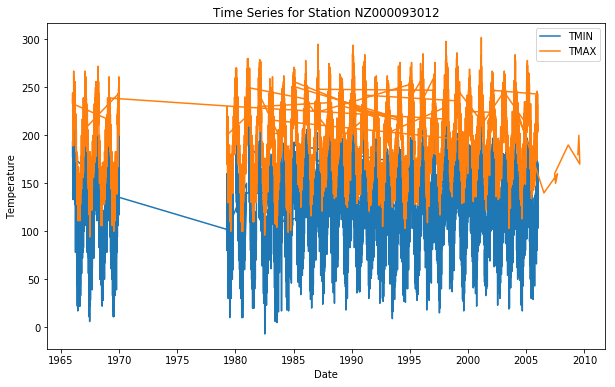

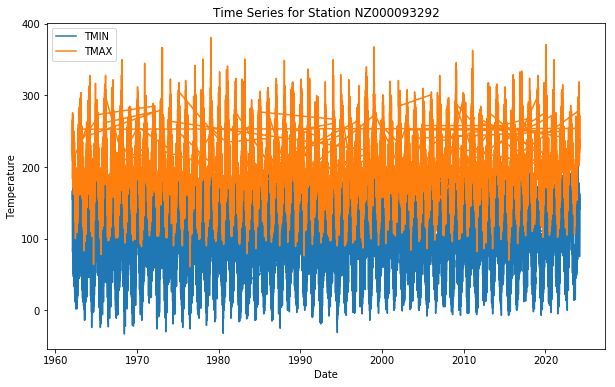

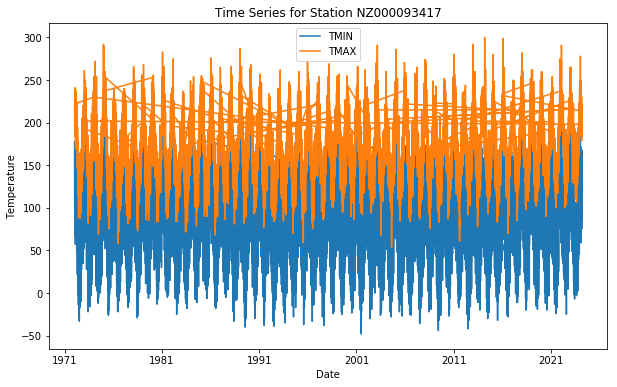

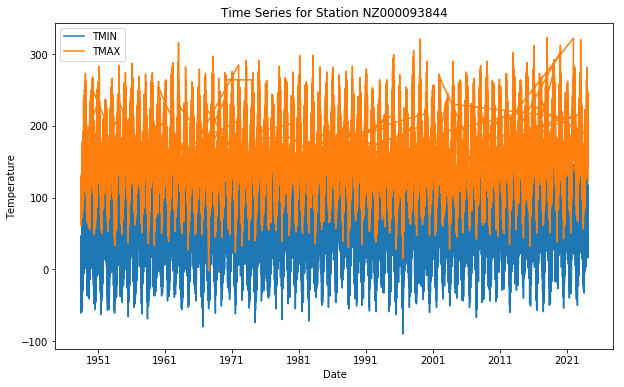

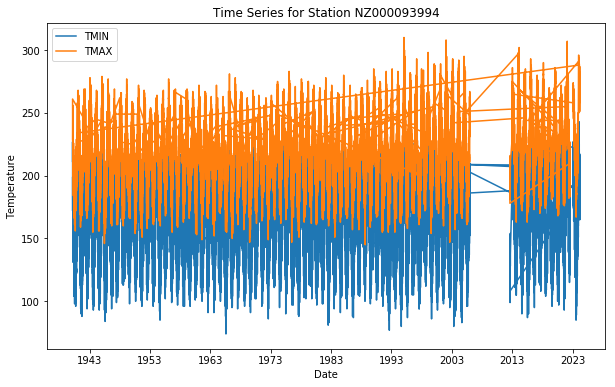

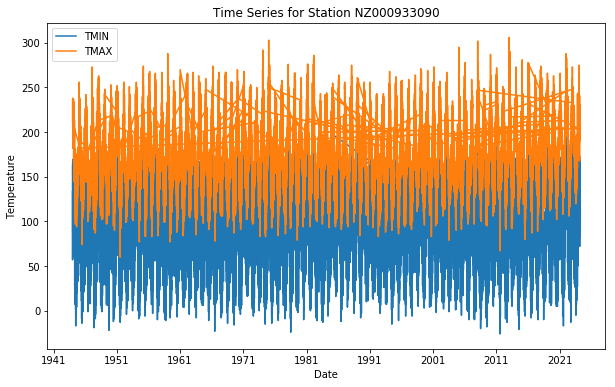

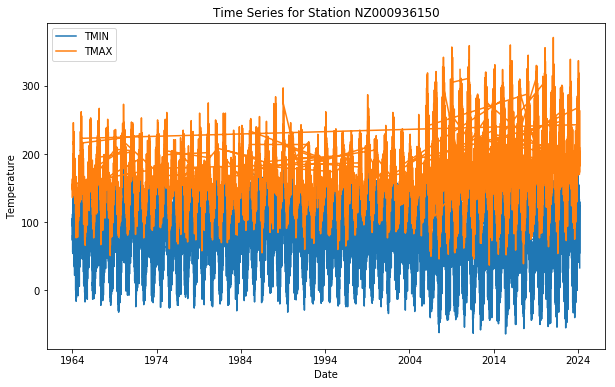

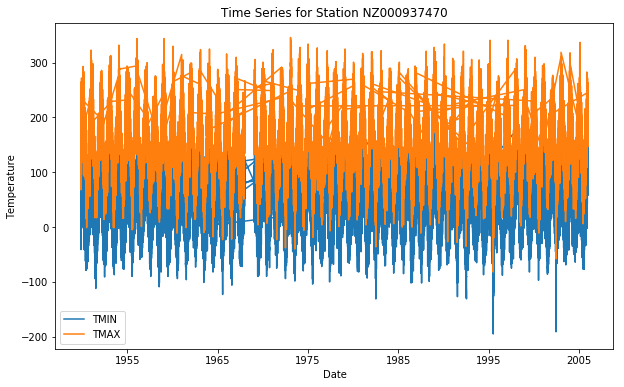

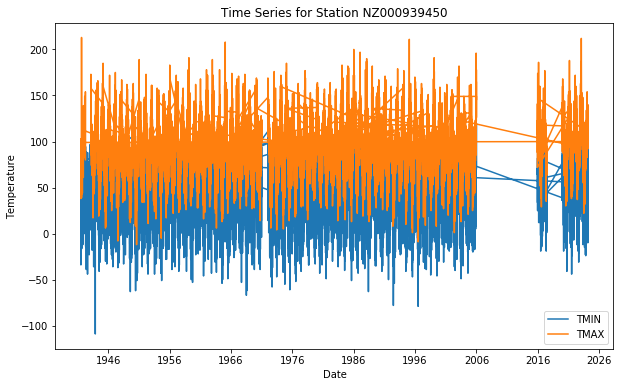

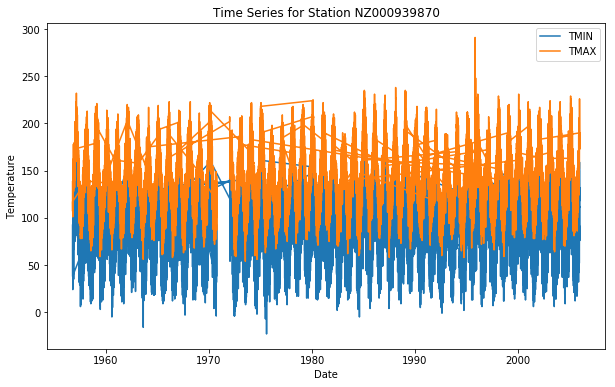

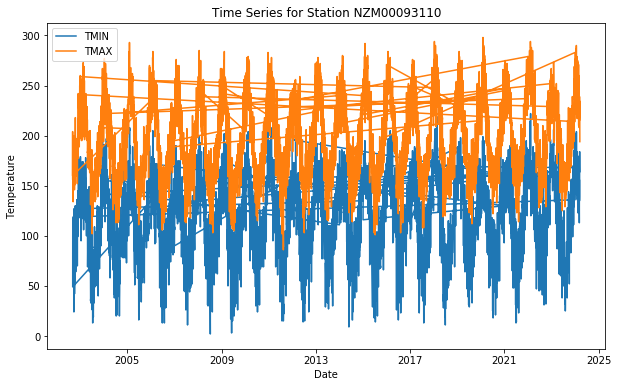

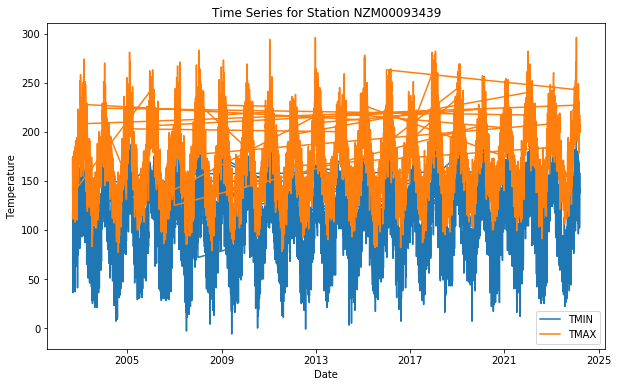

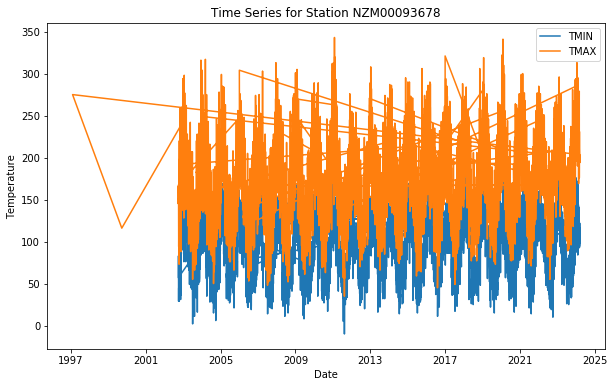

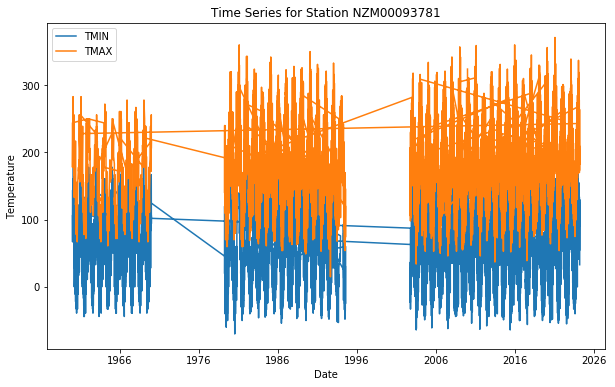

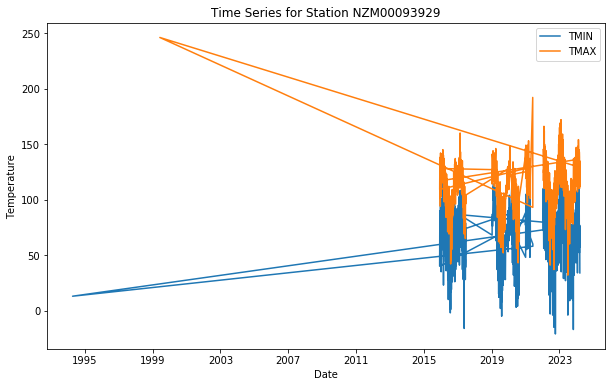

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
#nz_data = nz_data.toPandas()
nz_data['DATE'] = pd.to_datetime(nz_data['DATE'])
tmin_data = nz_data[nz_data['ELEMENT'] == 'TMIN']
tmax_data = nz_data[nz_data['ELEMENT'] == 'TMAX']

for station, group in pd.concat([tmin_data, tmax_data]).groupby('ID'):
    plt.figure(figsize=(10, 6))
    plt.plot(group[group['ELEMENT'] == 'TMIN']['DATE'], group[group['ELEMENT'] == 'TMIN']['VALUE'], label='TMIN')
    plt.plot(group[group['ELEMENT'] == 'TMAX']['DATE'], group[group['ELEMENT'] == 'TMAX']['VALUE'], label='TMAX')
    plt.title(f'Time Series for Station {station}')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

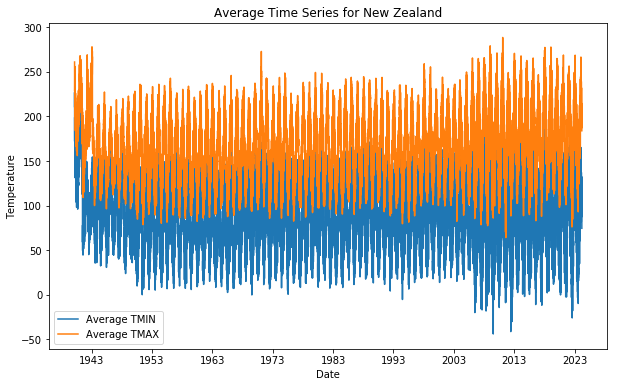

In [117]:
plt.figure(figsize=(10, 6))
plt.plot(tmin_data.groupby('DATE')['VALUE'].mean(), label='Average TMIN')
plt.plot(tmax_data.groupby('DATE')['VALUE'].mean(), label='Average TMAX')
plt.title('Average Time Series for New Zealand')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [68]:
limit_data = daily_all
limit_data.show()

+-----------+----------+-------+-----+----------------+------------+-----------+----------------+
|         ID|      DATE|ELEMENT|VALUE|MEASUREMENT FLAG|QUALITY FLAG|SOURCE FLAG|OBSERVATION TIME|
+-----------+----------+-------+-----+----------------+------------+-----------+----------------+
|AE000041196|2010-01-01|   TMAX|259.0|            null|        null|          S|            null|
|AE000041196|2010-01-01|   TMIN|120.0|            null|        null|          S|            null|
|AE000041196|2010-01-01|   TAVG|181.0|               H|        null|          S|            null|
|AEM00041194|2010-01-01|   TMAX|250.0|            null|        null|          S|            null|
|AEM00041194|2010-01-01|   TMIN|168.0|            null|        null|          S|            null|
|AEM00041194|2010-01-01|   PRCP|  0.0|            null|        null|          S|            null|
|AEM00041194|2010-01-01|   TAVG|194.0|               H|        null|          S|            null|
|AEM00041217|2010-01

+----+-------+------------------+
|YEAR|COUNTRY|      AVG_RAINFALL|
+----+-------+------------------+
|2009|     AM| 67.04719101123595|
|2009|     DR|232.35201890034364|
|2009|     KN|100.43801652892562|
|2009|     PA|210.25694023518002|
|2009|     PO|156.71862204509472|
|2009|     TH|252.33184808782542|
|2012|     EK|  240.923273657289|
|2012|     ES| 254.7022727272727|
|2012|     GG|123.69296034946237|
|2012|     NL|25.056893767927367|
|2012|     NO|62.565470762325454|
|2012|     TH|254.97846781504987|
|2012|     VQ|1022.2941868938842|
|2016|     CV|247.02723267921505|
|2016|     JO|188.07039815349106|
|2016|     PE|196.62690507620306|
|2016|     PO|133.44014447884416|
|2016|     SP|111.00644271428831|
|2016|     TO| 260.0129993658846|
|2016|     US|207.87294302279167|
+----+-------+------------------+
only showing top 20 rows



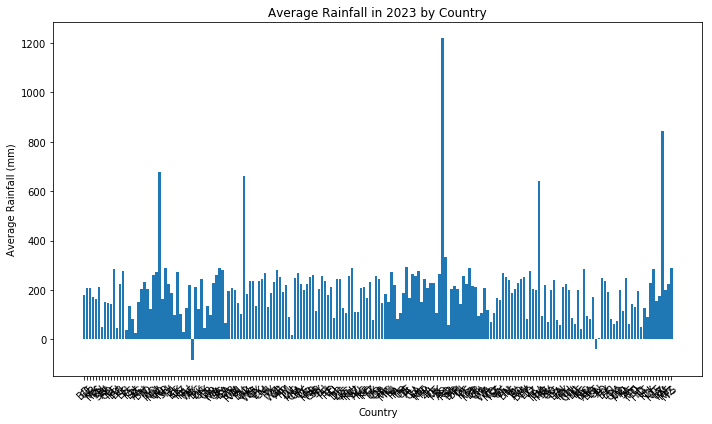

In [69]:
from pyspark.sql.functions import year, substring
import matplotlib.pyplot as plt
limit_data = limit_data.withColumn("COUNTRY", substring(limit_data["ID"], 1, 2))

avg_rainfall = limit_data.groupBy(year("DATE").alias("YEAR"), "COUNTRY").avg("VALUE")
avg_rainfall = avg_rainfall.withColumnRenamed("avg(VALUE)", "AVG_RAINFALL")
max_avg_rainfall = avg_rainfall.groupBy("COUNTRY").max("AVG_RAINFALL")
max_avg_rainfall = max_avg_rainfall.withColumnRenamed("max(AVG_RAINFALL)", "MAX_AVG_RAINFALL")
max_avg_rainfall = max_avg_rainfall.orderBy(max_avg_rainfall["MAX_AVG_RAINFALL"].desc()).limit(1)
avg_rainfall.show()

avg_rainfall.write.mode("overwrite").csv("output/average_rainfall_per_year_per_country")
avg_rainfall_2023 = avg_rainfall.filter(avg_rainfall["YEAR"] == 2023).toPandas()

plt.figure(figsize=(10, 6))
plt.bar(avg_rainfall_2023['COUNTRY'], avg_rainfall_2023['AVG_RAINFALL'])
plt.xlabel('Country')
plt.ylabel('Average Rainfall (mm)')
plt.title('Average Rainfall in 2023 by Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [92]:
from pyspark.sql.functions import desc

max_country = avg_rainfall.orderBy(desc("AVG_RAINFALL")).limit(1)
max_country.show()

+----+-------+-----------------+
|YEAR|COUNTRY|     AVG_RAINFALL|
+----+-------+-----------------+
|2015|     AQ|1676.331779661017|
+----+-------+-----------------+



In [94]:
country_AQ = countries.filter(countries["CODE"] == "AQ")
country_AQ.show()

+----+--------------------+
|CODE|                NAME|
+----+--------------------+
|  AQ|American Samoa [U...|
+----+--------------------+



In [15]:
file_nz = spark.read.csv("hdfs:///user/mli181/output/nz_data.csv", schema=schema)
file_nz.count()

44725

In [12]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()